In [1]:
import numpy as np
import pandas as pd

from nilearn import datasets
from nilearn.plotting import plot_matrix, show
from nilearn.maskers import NiftiMasker

import matplotlib.pyplot as plt


[get_dataset_dir] Dataset found in /home/akhil/nilearn_data/haxby2001

39912 8


/home/akhil/anaconda3/envs/sage/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 001  Train Loss: 2.960  Val Acc: 0.324  KL‑weight: 0.0001
Epoch 002  Train Loss: 2.217  Val Acc: 0.549  KL‑weight: 0.0001
Epoch 003  Train Loss: 1.610  Val Acc: 0.740  KL‑weight: 0.0001
Epoch 004  Train Loss: 1.185  Val Acc: 0.827  KL‑weight: 0.0002
Epoch 005  Train Loss: 1.059  Val Acc: 0.815  KL‑weight: 0.0003
Epoch 006  Train Loss: 0.984  Val Acc: 0.786  KL‑weight: 0.0003
Epoch 007  Train Loss: 0.983  Val Acc: 0.809  KL‑weight: 0.0004
Epoch 008  Train Loss: 0.985  Val Acc: 0.867  KL‑weight: 0.0004
Epoch 009  Train Loss: 0.882  Val Acc: 0.908  KL‑weight: 0.0004
Epoch 010  Train Loss: 0.878  Val Acc: 0.879  KL‑weight: 0.0005
Epoch 011  Train Loss: 0.856  Val Acc: 0.844  KL‑weight: 0.0006
Epoch 012  Train Loss: 0.885  Val Acc: 0.879  KL‑weight: 0.0006
Epoch 013  Train Loss: 0.823  Val Acc: 0.873  KL‑weight: 0.0007
Epoch 014  Train Loss: 0.856  Val Acc: 0.855  KL‑weight: 0.0007
Epoch 015  Train Loss: 0.815  Val Acc: 0.902  KL‑weight: 0.0008
Epoch 016  Train Loss: 0.766  Val Acc: 0

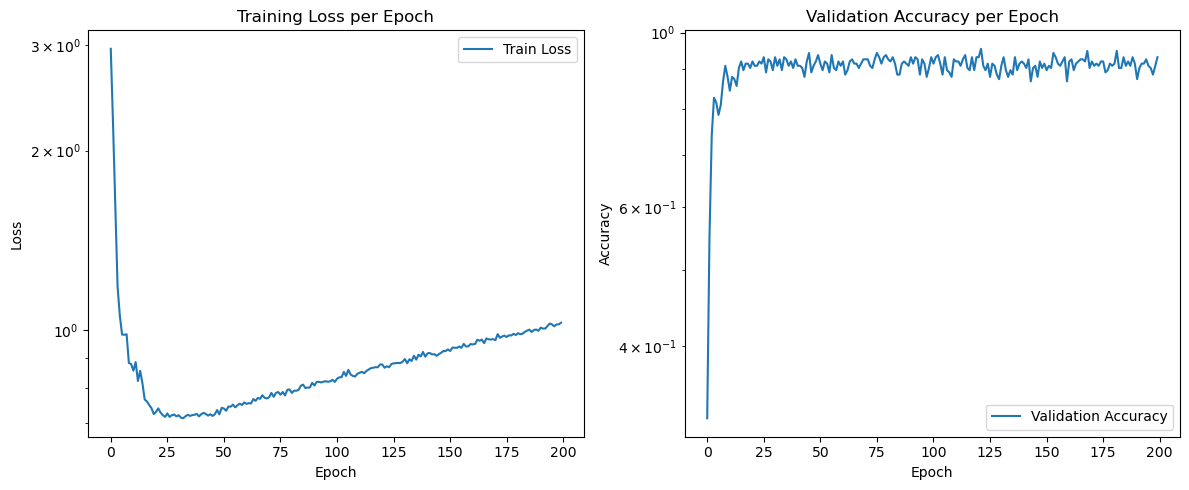

Final classifier accuracy: 0.7745664739884393


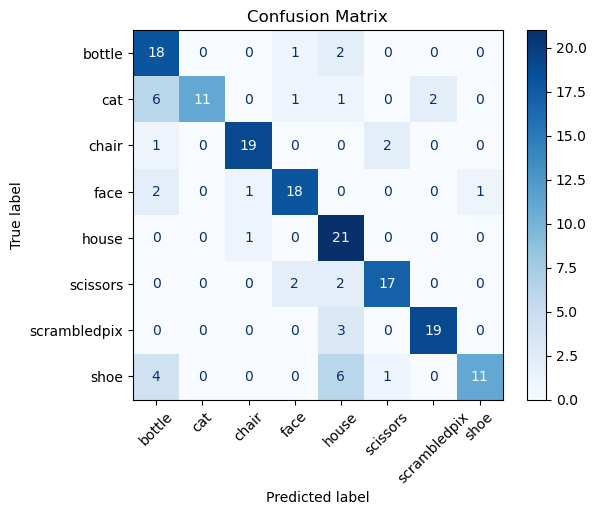

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from nilearn.datasets import fetch_haxby
from nilearn.maskers import NiftiMasker
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# === Data loading & preprocessing ===
haxby = fetch_haxby(subjects=[2])
func_filename = haxby.func[0]
mask_filename = haxby.mask
labels_df = pd.read_csv(haxby.session_target[0], sep=' ')
y = labels_df['labels'].values
run = labels_df['chunks'].values

runs_full = labels_df['chunks'].values

masker = NiftiMasker(
    mask_img=mask_filename,
    standardize='zscore_sample',
    runs=runs_full,
    smoothing_fwhm=4,
    memory='nilearn_cache',
    memory_level=1
)
X_full = masker.fit_transform(func_filename)
mask_nonrest = labels_df['labels'].values != 'rest'
X = X_full[mask_nonrest]
y = labels_df['labels'].values[mask_nonrest]

unique_conditions = np.unique(y)
num_classes = len(unique_conditions)
y_int = np.array([np.where(unique_conditions == lab)[0][0] for lab in y])

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y_int, test_size=0.2, random_state=42, stratify=y_int
)   

X_tr = torch.from_numpy(X_tr).float()
X_te = torch.from_numpy(X_te).float()
y_tr = torch.from_numpy(y_tr).long()
y_te = torch.from_numpy(y_te).long()

train_ds = TensorDataset(X_tr, y_tr)
test_ds  = TensorDataset(X_te, y_te)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False)

input_dim = X_tr.shape[1]
latent_dim = 64

class CVAE(nn.Module):
    def __init__(self, input_dim, latent_dim, num_classes, dropout=0.2):
        super().__init__()
        self.enc_fc1 = nn.Linear(input_dim, 256)
        self.enc_bn1 = nn.BatchNorm1d(256)
        self.enc_fc2 = nn.Linear(256, 128)
        self.enc_bn2 = nn.BatchNorm1d(128)
        self.dropout = nn.Dropout(dropout)
        self.fc_mu    = nn.Linear(128, latent_dim)
        self.fc_logvar= nn.Linear(128, latent_dim)
        self.classifier = nn.Linear(latent_dim, num_classes)
        self.dec_fc1 = nn.Linear(latent_dim + num_classes, 128)
        self.dec_bn1 = nn.BatchNorm1d(128)
        self.dec_fc2 = nn.Linear(128, 256)
        self.dec_bn2 = nn.BatchNorm1d(256)
        self.dec_out = nn.Linear(256, input_dim)

    def encode(self, x):
        h = F.relu(self.enc_bn1(self.enc_fc1(x)))
        h = self.dropout(h)
        h = F.relu(self.enc_bn2(self.enc_fc2(h)))
        h = self.dropout(h)
        mu      = self.fc_mu(h)
        log_var = self.fc_logvar(h)
        return mu, log_var

    def decode(self, z, y_onehot):
        z_cond = torch.cat([z, y_onehot], dim=1)
        h = F.relu(self.dec_bn1(self.dec_fc1(z_cond)))
        h = self.dropout(h)
        h = F.relu(self.dec_bn2(self.dec_fc2(h)))
        h = self.dropout(h)
        return self.dec_out(h)

    def forward(self, x, y_onehot):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        recon_x = self.decode(z, y_onehot)
        logits = self.classifier(z)
        return recon_x, logits, mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

def loss_function(recon_x, x, logits, y, mu, log_var,
                  recon_weight=1.0, kl_weight=0.01, class_weight=1.0):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    kl_element = 1 + log_var - mu.pow(2) - log_var.exp()
    kl_loss = (-0.5 * kl_element).sum(dim=1).mean()
    class_loss = F.cross_entropy(logits, y, reduction='mean')
    return (recon_weight * recon_loss
            + kl_weight    * kl_loss
            + class_weight * class_loss)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CVAE(input_dim, latent_dim, num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

kl_max = 0.01
kl_warmup_epochs = 200

train_losses = []
val_accuracies = []
best_val_acc = 0.0
best_model_path = 'best_model.pth'

for epoch in range(1, 201):
    kl_weight = kl_max * min(1.0, epoch / kl_warmup_epochs)
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        y_onehot = F.one_hot(yb, num_classes).float()
        optimizer.zero_grad()
        recon, logits, mu, log_var = model(xb, y_onehot)
        loss = loss_function(recon, xb, logits, yb, mu, log_var, kl_weight=kl_weight)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    model.eval()
    correct = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            mu, log_var = model.encode(xb)
            z = model.reparameterize(mu, log_var)
            preds = model.classifier(z).argmax(dim=1)
            correct += (preds == yb).sum().item()
    val_acc = correct / len(test_loader.dataset)

    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)

    scheduler.step(val_acc)

    print(f"Epoch {epoch:03d}  Train Loss: {train_loss:.3f}  Val Acc: {val_acc:.3f}  KL‑weight: {kl_weight:.4f}")

# === Plot training loss and val accuracy ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')  
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

# === Load best model ===
model.load_state_dict(torch.load(best_model_path))
model.eval()

class EncoderClassifier(nn.Module):
    def __init__(self, cvae):
        super().__init__()
        self.encoder = nn.Sequential(
            cvae.enc_fc1,
            nn.ReLU(),
            cvae.enc_fc2,
            nn.ReLU()
        )
        self.fc_mu  = cvae.fc_mu
        self.fc_log = cvae.fc_logvar
        self.classifier = cvae.classifier

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        z = mu
        return self.classifier(z)

clf = EncoderClassifier(model).to(device)
clf.eval()

correct = 0
all_preds = []
all_targets = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = clf(xb).argmax(dim=1)
        all_preds.append(preds.cpu())
        all_targets.append(yb.cpu())
        correct += (preds == yb).sum().item()

print("Final classifier accuracy:", correct / len(test_loader.dataset))

all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()
cm = confusion_matrix(all_targets, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_conditions)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()